In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sbn
import os
from functools import cmp_to_key
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from deepctr.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM
import pickle
from tensorflow.keras import layers
import time
from tensorflow import feature_column
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import sys
%matplotlib inline

In [2]:
print(tf.version.VERSION)
print('{}.{}'.format(sys.version_info.major,sys.version_info.minor))

2.1.0
3.6


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
def load_dict_from_file(file, type='default', skiprow = 0):
    data = list()
    size = 0
    with open(file, encoding='utf-8') as f:
        for line in f:
            size += 1
            try:
                if size <= skiprow:
                    continue
                line = line.replace('"', '').strip()
                if len(line) <= 0:
                    continue
                if type == 'interet':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10 and len(name) > 0:
                        data.append(name)
                elif type == 'loc':
                    parts = line.split(",")
                    province = parts[0]
                    city = parts[1]
                    area = parts[2]
                    data.append(province)
                    data.append(province + "_" + city)
                    data.append(province + "_" + city + "_" + area)
                elif type == 'publisher':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10:
                        data.append(name)
                else:
                    data.append(line)
            except:
                print(line)
    return data

def load_dict(dir, type='default', skiprow = 0):
    data = list()
    size = 0
    files = os.listdir(dir)
    for file in files:
        if not file.endswith(".csv"):
            continue
        data+=load_dict_from_file(dir + "/" + file, type, skiprow)
    return list(set(data))

def save_pickle_data(file, data):
    f = open(file, 'wb')
    pickle.dump(data, f)
    f.close()


def load_pickle_data(file):
    try:
        f1 = open(file, 'rb')
        return pickle.load(f1)
    except:
        pass
    return None

lbe_file = 'lbe.pickle'
data_map_file = 'data_map.pickle'

In [5]:
its = load_dict('/home/recsys/dataset/dict/interets', 'interet')
locs = load_dict('/home/recsys/dataset/dict/loc', 'loc')
publishers = load_dict('/home/recsys/dataset/dict/publisher', 'publisher', 1)
cates = load_dict_from_file('/home/recsys/dataset/dict/cate.csv', 'cate', 1)
channels = load_dict_from_file('/home/recsys/dataset/dict/channel.csv', 'channel', 1)
publishers.append('other')
channels.append('')

u_levels = [str(i) for i in range(0, 10)]
media_levels = [str(i) for i in range(0, 10)]
rschannles = [str(i) for i in range(1, 33)]
vocabs = dict()
vocabs['u_level'] = u_levels
vocabs['t_channel'] = channels
vocabs['cp_l1_category'] = cates
vocabs['cp_publisher'] = publishers
vocabs['cp_media_level'] = media_levels
vocabs['rschannles'] = rschannles

Sky game
中国新闻网,绥芬河政府网站,1
Ansun Biopharma, Inc.,1


In [6]:
len(vocabs)

6

In [7]:
def load_dataset(dir_path):
    files = os.listdir(dir_path)
    print(dir_path)
    dataset = tf.data.TFRecordDataset(filenames = [dir_path + '/' + file for file in files], num_parallel_reads= tf.data.experimental.AUTOTUNE )
    return dataset

In [8]:
path = "/home/recsys/dataset/train_v1/2020-05-25-16"

In [9]:
train = load_dataset(path+"/train")
test = load_dataset(path+"/test")

/home/recsys/dataset/train_v1/2020-05-25-16/train
/home/recsys/dataset/train_v1/2020-05-25-16/test


In [10]:
for raw_record in train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(type(example))

<class 'tensorflow.core.example.example_pb2.Example'>


In [11]:
import numpy as np

In [12]:
# 用于创建一个特征列
# 并转换一批次数据的一个实用程序方法
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    return feature_layer(example_batch).numpy()

###### 选择特征列 
uid, u_umi, u_umi_weight, u_uli, u_uli_weight, u_usi, u_usi_weight, u_level

t_channel, t_location

item_id, cp_l1_category, cp_interests, cp_location, cp_publisher, cp_media_level, cp_life_hour

rs_channel, rs_gactr, rs_taginfo, rs_taginfo_weight, rs_dactr

In [13]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

class NumpyFunctionHelper:
    def __init__(self, maxlen=None, dtype='int32', padding='post', truncating='post', value=0.0):
        self.maxlen = maxlen
        self.dtype = dtype
        self.padding = padding
        self.truncating = truncating
        self.value = value
        self.out_dtype = tf.int32
        if self.dtype == 'int64':
            self.out_dtype = tf.int64
        elif self.dtype == 'float32':
            self.out_dtype = tf.float32
        elif self.dtype == 'str':
            self.out_dtype = tf.string
        return

    def pad_sequences(self, x):
        # x will be a numpy array with the contents of the input to the
        # tf.function
        # note: x will be processed as a list of sequences
        return sequence.pad_sequences(x,
                                      maxlen = self.maxlen,
                                      dtype = self.dtype,
                                      padding = self.padding,
                                      truncating = self.truncating,
                                      value = self.value)

    # tf.numpy_function用于将一个numpy函数转换为一个tensor的operator，以便嵌入到计算图中处理Tensor
    # 构造一个能支持Tensor的填充截断函数
    # 调用方法NumpyFunctionHelper.tf_pad_sequences(helper, in_tensor)
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_sequences, [in_tensor], self.out_dtype)
        return y

    # 毫秒时间戳转换为local的struct_time
    def timestamp_to_time(self, ts):
        st = time.localtime(ts/1000)
        return tf.constant([st.tm_mon, st.tm_mday, st.tm_hour, st.tm_min, st.tm_wday])

    @tf.function(experimental_relax_shapes=True)
    def tf_timestamp_to_time(self, ts):
        y = tf.py_function(self.timestamp_to_time, ts, self.out_dtype)
        return y
    
    def pad_float_sequences(self, x):
        lst = x.tolist()
        res = []
        if len(x) < self.maxlen:
            for i in range(self.maxlen - len(x)):
                res.append(0.0)

        return np.asarray(lst + res, dtype=np.float32)[:self.maxlen]
    
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_float_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_float_sequences, [in_tensor], tf.float32)
        return y
    
    def pad_str_sequences(self, x):
        lst = x.tolist()
        res = []
        if len(x) < self.maxlen:
            for i in range(self.maxlen - len(x)):
                res.append(b'<PAD>')

        return np.asarray(lst + res)[:self.maxlen]
    
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_str_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_str_sequences, [in_tensor], tf.string)
        return y

In [14]:
spc = "t_location:3;u_uli_interest:150;u_uli_interest_weight:150;u_uli_cate:20;u_uli_cate_weight:20;"\
+"u_umi_interest:150;u_umi_interest_weight:150;u_umi_cate:20;u_umi_cate_weight:20;"\
+"u_usi_interest:15;u_usi_interest_weight:15;u_usi_cate:5;u_usi_cate_weight:5;"\
+"cp_category:3;cp_category_weight:3;cp_interests:8;cp_interests_weight:8;cp_location:3;cp_location_weight:3;"\
+"rs_channel:32;"\
+"rs_tag_interest:8;rs_tag_interest_dactr:8;rs_tag_cate:3;rs_tag_cate_dactr:3"
sparse_configs = [{'key':item.split(":")[0], 'max_len':int(item.split(":")[1])} for item in spc.split(";")]

In [15]:
for config in sparse_configs:
    key = config['key']
    max_len = config['max_len']
    dtype=tf.string
    value=b'<PAD>'
    if key.endswith('weight') or key.endswith('dactr'):
        dtype=tf.float32
        value=0.0

In [40]:
def parse_function(example_proto):
    dics = {
            'request_id':tf.io.FixedLenFeature(shape=(),dtype=tf.string, default_value=''),
            'report_time': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            't_language': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_country': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_pid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_ip': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_channel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_scene': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            't_ctype': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             't_location': tf.io.VarLenFeature(dtype=tf.string),
            'uid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'u_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'u_uli_interest': tf.io.VarLenFeature(dtype=tf.string),
#             'u_uli_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_uli_cate': tf.io.VarLenFeature(dtype=tf.string),
#             'u_uli_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_umi_interest': tf.io.VarLenFeature(dtype=tf.string),
#             'u_umi_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_umi_cate': tf.io.VarLenFeature(dtype=tf.string),
#             'u_umi_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_usi_interest': tf.io.VarLenFeature(dtype=tf.string),
#             'u_usi_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_usi_cate': tf.io.VarLenFeature(dtype=tf.string),
#             'u_usi_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'item_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'cp_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'cp_media_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_publish_time': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_life_hour': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_newsy_score': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0),
            'cp_word_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_category': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_category_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'cp_interests': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_interests_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'cp_location': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_location_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'cp_list_image_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_clickbait_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_vulgar_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_product_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_is_local': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_is_local_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'rs_channel': tf.io.VarLenFeature(dtype=tf.string),
            'rs_p1_score': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0.0),
            'rs_gactr': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0.0),
#             'rs_tag_interest': tf.io.VarLenFeature(dtype=tf.string),
#             'rs_tag_interest_dactr': tf.io.VarLenFeature(dtype=tf.float32),
#             'rs_tag_cate': tf.io.VarLenFeature(dtype=tf.string),
#             'rs_tag_cate_dactr': tf.io.VarLenFeature(dtype=tf.float32),
            'action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
           }
    # parse all features in a single example according to the dics
    parsed_example = tf.io.parse_single_example(example_proto, dics)
#     for config in sparse_configs:
#         key = config['key']
#         print(key)
#         dtype='str'
#         value=b'<PAD>'
#         if key.endswith('weight') or key.endswith('dactr'):
#             dtype=tf.float32
#             value=0.0
#             h = NumpyFunctionHelper(maxlen=config['max_len'], dtype=dtype, value=value)
#             parsed_example[key] = NumpyFunctionHelper.tf_pad_float_sequences(h, tf.sparse.to_dense(parsed_example[key]))
#             parsed_example[key].set_shape([config['max_len']])
#         else:
#             h = NumpyFunctionHelper(maxlen=config['max_len'], dtype=dtype, value=value)
#             parsed_example[key] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example[key]))
#             parsed_example[key].set_shape([config['max_len']])
    
    parsed_example['cp_media_level'] = tf.strings.as_string(parsed_example['cp_media_level'])
    parsed_example['u_level'] = tf.strings.as_string(parsed_example['u_level'])
    target = parsed_example['action']
    del parsed_example['action']
    return parsed_example, target
train_dataset = train.map(parse_function)
test_dataset = test.map(parse_function)

new_dataset = train_dataset
new_dataset = new_dataset.batch(2)
example_batch = next(iter(new_dataset))[0]

# # feature_column.categorical_column_with_vocabulary_list(key='u_level', vocabulary_list=u_levels, num_oov_buckets=1)
for feature_batch, label_batch in new_dataset.take(1):
    print('Every feature:', list(feature_batch.keys()))
#     print('A batch of u_uli:', feature_batch['u_uli'])
    print('A batch of request_id:', feature_batch['request_id'])
#     print('A batch of item_id:', feature_batch['u_uli'])
    print('A batch of cp_clickbait_type:', feature_batch['cp_clickbait_type'])
    print('A batch of targets:', label_batch )


Every feature: ['cp_clickbait_type', 'cp_is_local', 'cp_is_local_publisher', 'cp_life_hour', 'cp_list_image_count', 'cp_media_level', 'cp_newsy_score', 'cp_product_type', 'cp_publish_time', 'cp_publisher', 'cp_vulgar_type', 'cp_word_count', 'item_id', 'report_time', 'request_id', 'rs_gactr', 'rs_p1_score', 't_action', 't_channel', 't_country', 't_ctype', 't_ip', 't_language', 't_pid', 't_scene', 'u_level', 'uid']
A batch of request_id: tf.Tensor(
[b'852cf20c042f69b5c47d4c205cb2fc391df5da6a'
 b'e32b9f6ad6054f0d1ced3ab2ded76d52f7743f85'], shape=(2,), dtype=string)
A batch of cp_clickbait_type: tf.Tensor([0 0], shape=(2,), dtype=int64)
A batch of targets: tf.Tensor([0 0], shape=(2,), dtype=int64)


In [41]:
# 创建特征列
feature_columns = []
feature_layer_inputs = {}
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            ('rs_gactr,rs_p1_score,cp_is_local_publisher,cp_is_local,cp_vulgar_type,cp_clickbait_type' +
             ',cp_word_count,cp_newsy_score,cp_life_hour').split(',')
}
sparse = {
    't_channel': tf.feature_column.categorical_column_with_vocabulary_list('t_channel', vocabulary_list=channels),
    'uid'   : tf.feature_column.categorical_column_with_hash_bucket('uid', hash_bucket_size=300000),
    'u_level' : tf.feature_column.categorical_column_with_vocabulary_list('u_level', vocabulary_list=u_levels),
    'item_id'   : tf.feature_column.categorical_column_with_hash_bucket('item_id', hash_bucket_size=300000),
    'cp_publisher': tf.feature_column.categorical_column_with_vocabulary_list('cp_publisher', vocabulary_list=publishers),
    'cp_media_level' : tf.feature_column.categorical_column_with_vocabulary_list('cp_media_level', vocabulary_list=media_levels),
#     'rs_channel': tf.feature_column.categorical_column_with_vocabulary_list('rs_channel', vocabulary_list=rschannles),
}

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(1,), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(1,), dtype='string') 
          for colname in sparse.keys()
})

In [42]:
def get_dimen(col):
    if col == 'uid':
        return 32
    elif col == 'uid':
        return 32
    elif col == 'cp_publisher':
        return 16
    else:
        return 6

In [43]:
#特征工程
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, get_dimen(col))
          for colname, col in sparse.items()
}
real.update(embed)

In [44]:
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

In [45]:
DNN_HIDDEN_UNITS = '64,32'

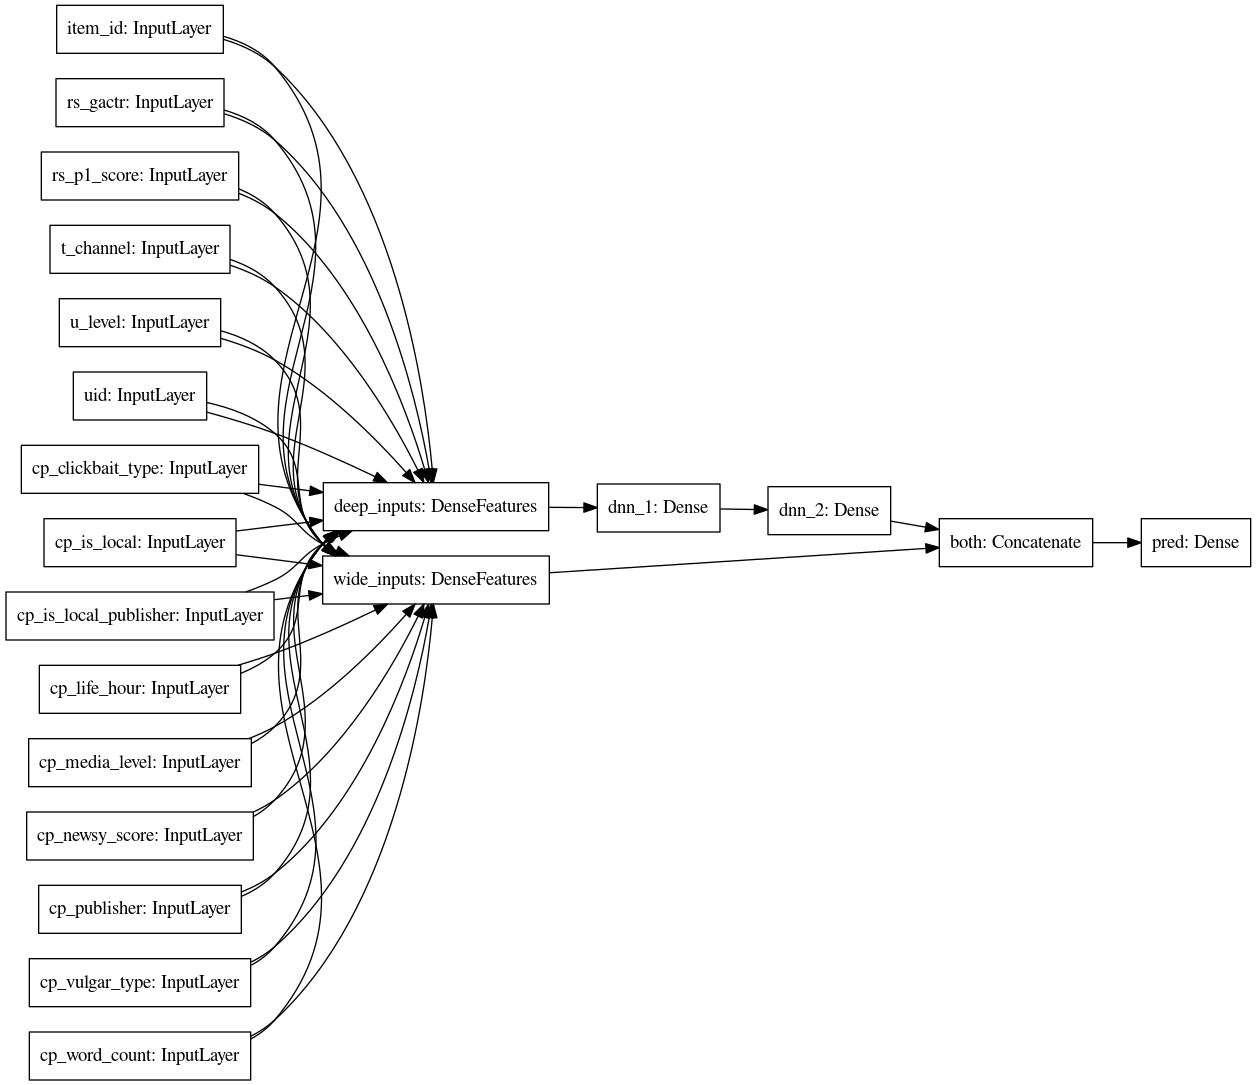

In [46]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy', 'accuracy', tf.keras.metrics.AUC()],
              run_eagerly=True)
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'wide_and_deep_model.png', show_shapes=False, rankdir='LR')

In [47]:
buffer_size = 5000
batch_size = 128

In [48]:
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat(2)
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)

In [ ]:
# 模型训练
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=1)])

Epoch 1/10
   2475/Unknown - 1501s 606ms/step - loss: 0.3170 - binary_crossentropy: 0.3170 - accuracy: 0.9013 - auc_2: 0.6188

In [110]:

# feature_columns.append(feature_column.numeric_column("rs_gactr"))
# feature_layer_inputs["rs_gactr"] = tf.keras.Input(shape=(1,), name="rs_gactr", dtype='float32')

# # item_id_hash = feature_column.categorical_column_with_hash_bucket('item_id', hash_bucket_size=500000)
# # item_id_one_hot = feature_column.indicator_column(item_id_hash)
# # feature_columns.append(item_id_one_hot)
# # feature_layer_inputs['item_id'] = tf.keras.Input(shape=(1,), name='item_id', dtype=tf.string)
# # item_id_embedding = feature_column.embedding_column(item_id_hash, dimension=64)
# # feature_columns.append(item_id_embedding)

# # uid_hash = feature_column.categorical_column_with_hash_bucket('uid', hash_bucket_size=500000)
# # uid_embedding = feature_column.embedding_column(uid_hash, dimension=64)
# # feature_columns.append(uid_embedding)
# # feature_layer_inputs["uid"] = tf.keras.Input(shape=(), name="uid", dtype='string')

# # u_uli = feature_column.categorical_column_with_hash_bucket('u_uli', hash_bucket_size=30000, dtype=tf.string)
# # u_uli_one_hot = feature_column.indicator_column(u_uli)
# # feature_columns.append(u_uli_one_hot)
# # feature_layer_inputs["u_uli"] = tf.keras.Input(shape=(300,), name="u_uli", dtype=tf.string)
# # u_uli_embedding = feature_column.embedding_column(u_uli, dimension=64)
# # feature_columns.append(u_uli_embedding)

# # feature_layer_inputs["u_uli"] = tf.keras.Input(shape=(1,), sparse=True, dtype=tf.string, name="u_uli")

# # u_umi = feature_column.categorical_column_with_vocabulary_list('u_umi', vocabulary_list=its, num_oov_buckets=1)
# # u_umi_embedding = feature_column.embedding_column(u_umi, dimension=64)
# # feature_columns.append(u_umi_embedding)

# # u_usi = feature_column.categorical_column_with_vocabulary_list('u_usi', vocabulary_list=its, num_oov_buckets=1)
# # u_usi_embedding = feature_column.embedding_column(u_usi, dimension=64)
# # feature_columns.append(u_usi_embedding)

# # u_level = feature_column.categorical_column_with_vocabulary_list('u_level', vocabulary_list=u_levels, num_oov_buckets=1)
# # u_level_one_hot = feature_column.indicator_column(u_level)
# # feature_columns.append(u_level_one_hot)

# # t_channel = feature_column.categorical_column_with_vocabulary_list('t_channel', vocabulary_list=channels, num_oov_buckets=1)
# # t_channel_one_hot = feature_column.indicator_column(t_channel)
# # feature_columns.append(t_channel_one_hot)

# # t_location = feature_column.categorical_column_with_vocabulary_list('t_location', vocabulary_list=locs, num_oov_buckets=1)
# # t_location_one_hot = feature_column.indicator_column(t_location)
# # feature_columns.append(t_location_one_hot)

# # cp_media_level = feature_column.categorical_column_with_vocabulary_list('cp_media_level', vocabulary_list=media_levels, num_oov_buckets=1)
# # cp_media_level_one_hot = feature_column.indicator_column(cp_media_level)
# # feature_columns.append(cp_media_level_one_hot)

# # cp_publisher = feature_column.categorical_column_with_vocabulary_list('cp_publisher', vocabulary_list=publishers, num_oov_buckets=1)
# # cp_publisher_one_hot = feature_column.indicator_column(cp_publisher)
# # feature_columns.append(cp_publisher_one_hot)

# # cp_location = feature_column.categorical_column_with_vocabulary_list('cp_location', vocabulary_list=locs, num_oov_buckets=1)
# # cp_location_embedding = feature_column.embedding_column(cp_location, dimension=8)
# # feature_columns.append(cp_location_embedding)

# # cp_life_hour = feature_column.numeric_column("cp_life_hour")
# # cp_life_hour = feature_column.bucketized_column(cp_life_hour, boundaries=[72, 24 * 7, 24 * 14, 24 * 30])
# # feature_columns.append(cp_life_hour)

# # rs_channel = feature_column.categorical_column_with_vocabulary_list('rs_channel', vocabulary_list=rschannles, num_oov_buckets=1)
# # rs_channel_embedding = feature_column.embedding_column(rs_channel, dimension=6)
# # feature_columns.append(rs_channel_embedding)

# # rs_taginfo = feature_column.categorical_column_with_vocabulary_list('rs_taginfo', vocabulary_list=its, num_oov_buckets=1)
# # rs_taginfo_embedding = feature_column.embedding_column(rs_taginfo, dimension=8)
# # feature_columns.append(rs_taginfo_embedding)

# # rs_taginfo = feature_column.categorical_column_with_hash_bucket('rs_taginfo', hash_bucket_size=30000, dtype=tf.string)
# # rs_taginfo_one_hot = feature_column.indicator_column(rs_taginfo)
# # feature_columns.append(rs_taginfo_one_hot)
# # feature_layer_inputs["rs_taginfo"] = tf.keras.Input(shape=(10,), name="rs_taginfo", dtype=tf.string)
# # rs_taginfo_embedding = feature_column.embedding_column(rs_taginfo, dimension=8)
# # feature_columns.append(rs_taginfo_embedding)

# #构造输入特征
# feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
# feature_layer_outputs = feature_layer(feature_layer_inputs)
# batch_size = 128
# buffer_size = 5000
# train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat(1)
# test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)


# #定义模型
# dense1 = tf.keras.layers.Dense(128, activation='relu')(feature_layer_outputs)
# dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
# dense3 = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
# model = tf.keras.Model(inputs=feature_layer_inputs, outputs=dense3)

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_crossentropy', 'accuracy', tf.keras.metrics.AUC()],
#               run_eagerly=True)

# # 模型训练
# model.fit(train_dataset,
#           validation_data=test_dataset,
#           epochs=10)